# EXIST2025 - Data Exploration

This notebook performs comprehensive exploratory data analysis on the EXIST2025 sexism detection dataset.

## Objectives
- Load and examine dataset structure
- Analyze label distributions across tasks
- Evaluate inter-annotator agreement
- Identify class imbalance patterns
- Compute text statistics
- Verify data splits

In [22]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Dataset

In [23]:
# Define paths
DATA_DIR = Path('lab1_materials')
DATASET_DIR = DATA_DIR / 'dataset_task1_exist2025'
GOLDS_DIR = DATA_DIR / 'golds_task1_exist2025'

# Load training data
with open(DATASET_DIR / 'training.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)

# Load test data
with open(DATASET_DIR / 'test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# Load gold standard labels
with open(GOLDS_DIR / 'training.json', 'r', encoding='utf-8') as f:
    gold_labels = json.load(f)

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Gold labels: {len(gold_labels)}")

Training samples: 6064
Test samples: 934
Gold labels: 6064


## 2. Dataset Structure Analysis

In [24]:
# Examine first sample
sample_id = list(train_data.keys())[0]
sample = train_data[sample_id]

print("Sample structure:")
for key, value in sample.items():
    if isinstance(value, list) and len(value) > 3:
        print(f"  {key}: {value[:3]} ... ({len(value)} items)")
    else:
        print(f"  {key}: {value}")

Sample structure:
  id_EXIST: 100001
  lang: es
  tweet: @TheChiflis Ignora al otro, es un capullo.El problema con este youtuber denuncia el acoso... cuando no afecta a la gente de izquierdas. Por ejemplo, en su video sobre el gamergate presenta como "normal" el acoso que reciben Fisher, Anita o Zöey cuando hubo hasta amenazas de bomba.
  number_annotators: 6
  annotators: ['Annotator_1', 'Annotator_2', 'Annotator_3'] ... (6 items)
  gender_annotators: ['F', 'F', 'F'] ... (6 items)
  age_annotators: ['18-22', '23-45', '46+'] ... (6 items)
  ethnicities_annotators: ['White or Caucasian', 'Hispano or Latino', 'White or Caucasian'] ... (6 items)
  study_levels_annotators: ['Bachelor’s degree', 'Bachelor’s degree', 'High school degree or equivalent'] ... (6 items)
  countries_annotators: ['Italy', 'Mexico', 'United States'] ... (6 items)
  labels_task1: ['YES', 'YES', 'NO'] ... (6 items)
  labels_task2: ['REPORTED', 'JUDGEMENTAL', '-'] ... (6 items)
  labels_task3: [['OBJECTIFICATION'], ['

In [25]:
# Convert to DataFrame for easier analysis
def json_to_dataframe(data_dict):
    records = []
    for tweet_id, tweet_data in data_dict.items():
        record = {
            'id': tweet_data['id_EXIST'],
            'tweet': tweet_data['tweet'],
            'split': tweet_data.get('split', 'DEV_ES'),
            'num_annotators': tweet_data.get('number_annotators', 0),
            'labels_task1': tweet_data.get('labels_task1', []),
            'labels_task2': tweet_data.get('labels_task2', []),
            'labels_task3': tweet_data.get('labels_task3', [])
        }
        records.append(record)
    return pd.DataFrame(records)

df_train = json_to_dataframe(train_data)
df_test = json_to_dataframe(test_data)

print("\nTraining DataFrame:")
print(df_train.head())
print(f"\nShape: {df_train.shape}")


Training DataFrame:
       id                                              tweet     split  \
0  100001  @TheChiflis Ignora al otro, es un capullo.El p...  TRAIN_ES   
1  100002  @ultimonomada_ Si comicsgate se parece en algo...  TRAIN_ES   
2  100003  @Steven2897 Lee sobre Gamergate, y como eso ha...  TRAIN_ES   
3  100005  @novadragon21 @icep4ck @TvDannyZ Entonces como...  TRAIN_ES   
4  100006  @yonkykong Aaah sí. Andrew Dobson. El que se d...  TRAIN_ES   

   num_annotators                   labels_task1  \
0               6  [YES, YES, NO, YES, YES, YES]   
1               6      [NO, NO, NO, NO, YES, NO]   
2               6       [NO, NO, NO, NO, NO, NO]   
3               6   [YES, NO, YES, NO, YES, YES]   
4               6       [NO, NO, NO, NO, NO, NO]   

                                        labels_task2  \
0  [REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...   
1                            [-, -, -, -, DIRECT, -]   
2                                 [-, -, -, -, -, -] 

## 3. Label Distribution Analysis

### Task 1: Binary Sexism Detection

In [26]:
# Aggregate Task 1 labels using majority voting
def majority_vote(labels):
    if not labels:
        return None
    counter = Counter(labels)
    return counter.most_common(1)[0][0]

df_train['task1_majority'] = df_train['labels_task1'].apply(majority_vote)
df_test['task1_majority'] = df_test['labels_task1'].apply(majority_vote)

# Task 1 distribution
task1_counts = df_train['task1_majority'].value_counts()
print("Task 1 Distribution (Training):")
print(task1_counts)
print(f"\nClass balance ratio: {task1_counts['YES'] / task1_counts['NO']:.2f}")

Task 1 Distribution (Training):
task1_majority
NO     3367
YES    2697
Name: count, dtype: int64

Class balance ratio: 0.80


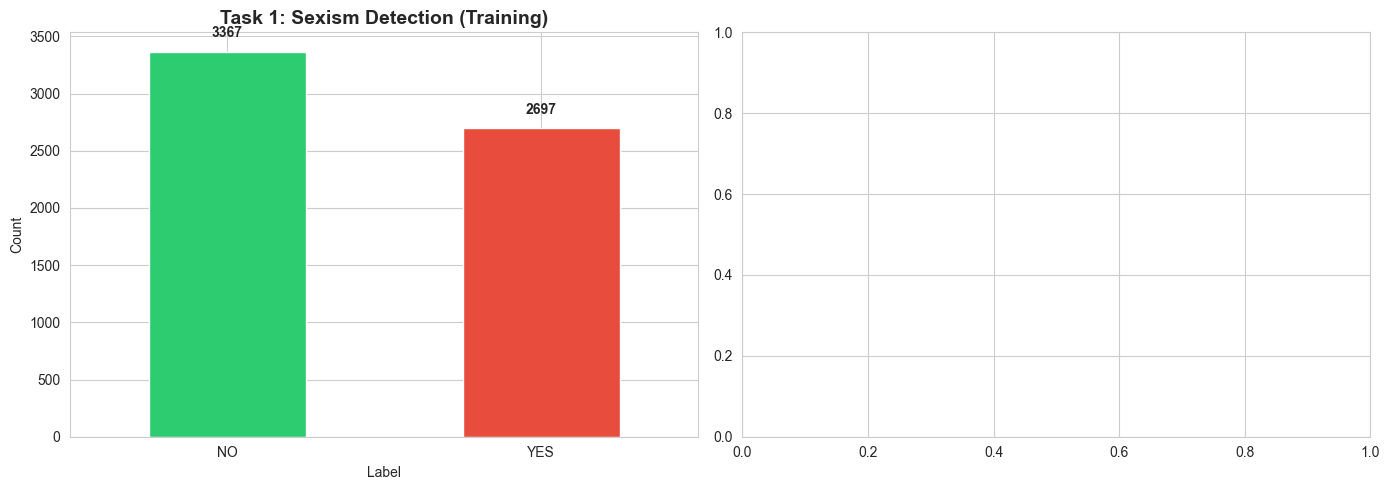

In [27]:
# Visualize Task 1 distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
task1_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Task 1: Sexism Detection (Training)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['NO', 'YES'], rotation=0)
for i, v in enumerate(task1_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

# Test set
task1_test_counts = df_test['task1_majority'].value_counts()
if len(task1_test_counts) > 0:
    task1_test_counts.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
    axes[1].set_title('Task 1: Sexism Detection (Test)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Count')
    axes[1].set_xticklabels(task1_test_counts.index, rotation=0)

plt.tight_layout()
plt.show()

### Task 2: Sexism Type Classification

In [28]:
# Analyze Task 2 labels (only for sexist tweets)
def flatten_task2_labels(df):
    task2_labels = []
    for labels in df['labels_task2']:
        for label in labels:
            if label != '-':
                task2_labels.append(label)
    return task2_labels

task2_all = flatten_task2_labels(df_train)
task2_counts = Counter(task2_all)

print("Task 2 Distribution (Training):")
for label, count in task2_counts.most_common():
    print(f"  {label}: {count}")

Task 2 Distribution (Training):
  DIRECT: 7825
  JUDGEMENTAL: 4251
  REPORTED: 4036
  UNKNOWN: 73


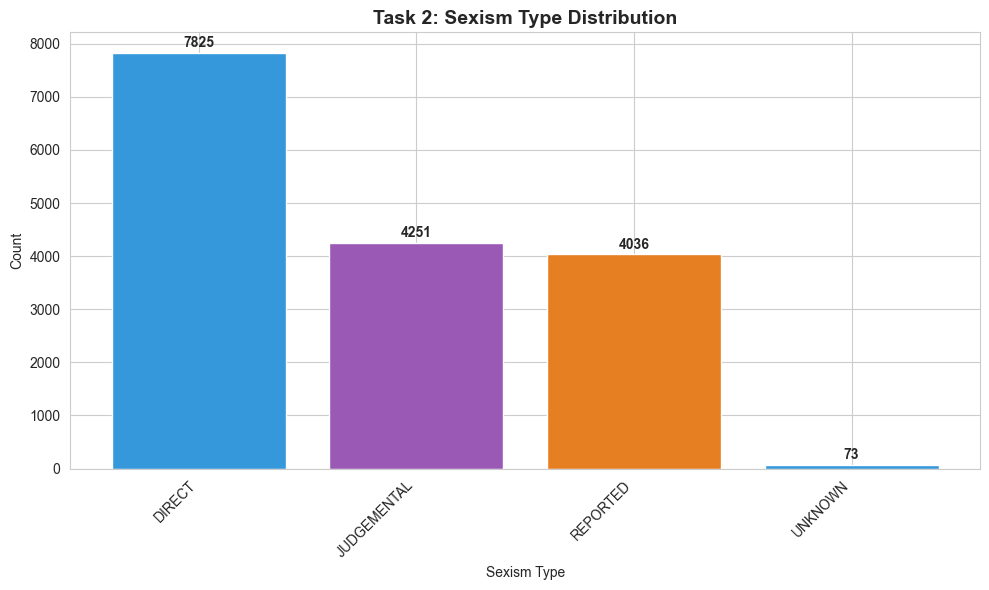

In [29]:
# Visualize Task 2 distribution
plt.figure(figsize=(10, 6))
labels, counts = zip(*task2_counts.most_common())
plt.bar(labels, counts, color=['#3498db', '#9b59b6', '#e67e22'])
plt.title('Task 2: Sexism Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sexism Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(counts):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

### Task 3: Sexism Categories (Multi-label)

In [30]:
# Analyze Task 3 labels (multi-label)
def flatten_task3_labels(df):
    task3_labels = []
    for labels_list in df['labels_task3']:
        for annotator_labels in labels_list:
            for label in annotator_labels:
                if label != '-':
                    task3_labels.append(label)
    return task3_labels

task3_all = flatten_task3_labels(df_train)
task3_counts = Counter(task3_all)

print("Task 3 Distribution (Training):")
for label, count in task3_counts.most_common():
    print(f"  {label}: {count}")

Task 3 Distribution (Training):
  STEREOTYPING-DOMINANCE: 5969
  IDEOLOGICAL-INEQUALITY: 5006
  OBJECTIFICATION: 4528
  MISOGYNY-NON-SEXUAL-VIOLENCE: 3620
  SEXUAL-VIOLENCE: 2876
  UNKNOWN: 180


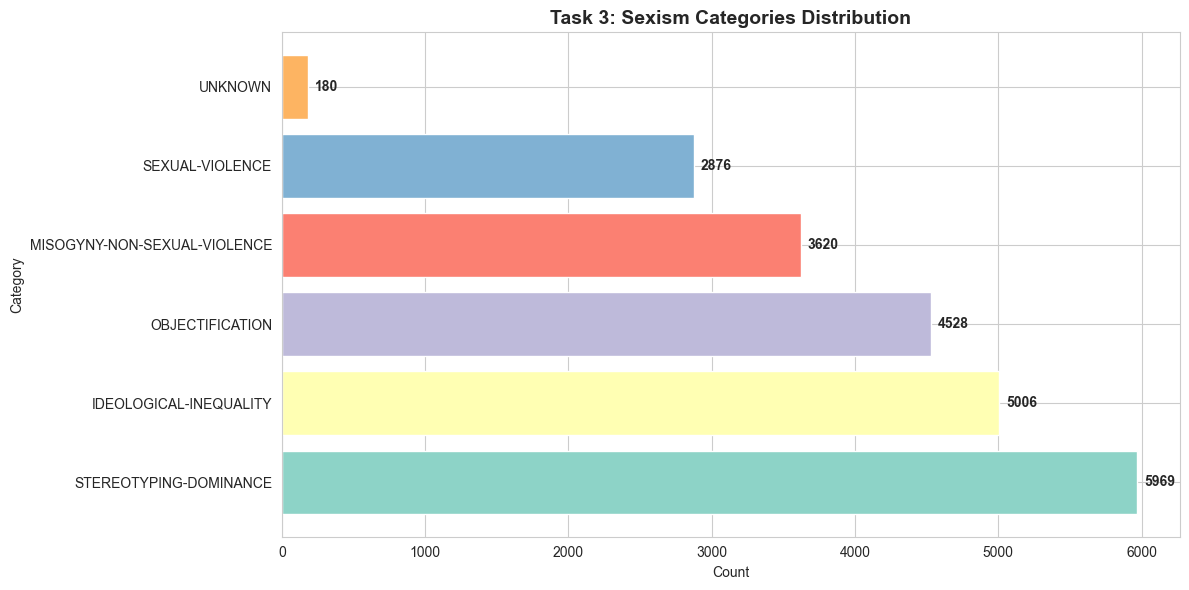

In [31]:
# Visualize Task 3 distribution
plt.figure(figsize=(12, 6))
labels, counts = zip(*task3_counts.most_common())
colors = plt.cm.Set3(range(len(labels)))
plt.barh(labels, counts, color=colors)
plt.title('Task 3: Sexism Categories Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Category')
for i, v in enumerate(counts):
    plt.text(v + 50, i, str(v), va='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Inter-Annotator Agreement Analysis

In [32]:
# Calculate agreement metrics for Task 1
def calculate_agreement(labels_list):
    if not labels_list:
        return 0
    counter = Counter(labels_list)
    max_agreement = max(counter.values())
    return max_agreement / len(labels_list)

df_train['task1_agreement'] = df_train['labels_task1'].apply(calculate_agreement)
df_test['task1_agreement'] = df_test['labels_task1'].apply(calculate_agreement)

print("Task 1 Inter-Annotator Agreement Statistics:")
print(df_train['task1_agreement'].describe())

Task 1 Inter-Annotator Agreement Statistics:
count    6064.000000
mean        0.846443
std         0.135094
min         0.666667
25%         0.666667
50%         0.833333
75%         1.000000
max         1.000000
Name: task1_agreement, dtype: float64


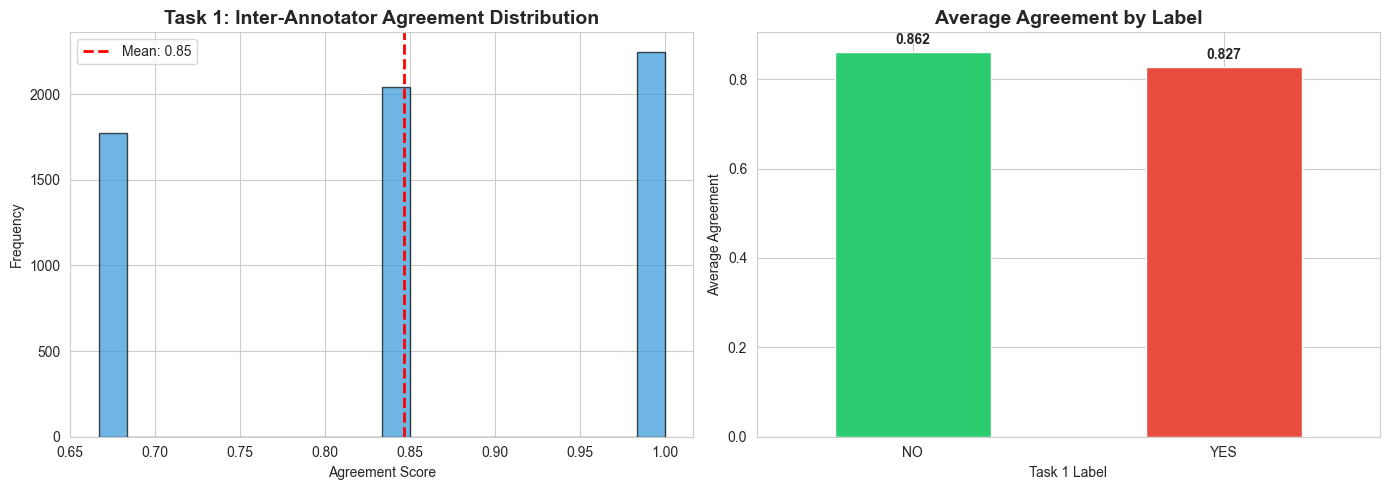

In [33]:
# Visualize agreement distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Agreement histogram
axes[0].hist(df_train['task1_agreement'], bins=20, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_title('Task 1: Inter-Annotator Agreement Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Agreement Score')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df_train['task1_agreement'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df_train["task1_agreement"].mean():.2f}')
axes[0].legend()

# Agreement by label
agreement_by_label = df_train.groupby('task1_majority')['task1_agreement'].mean()
agreement_by_label.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Average Agreement by Label', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Task 1 Label')
axes[1].set_ylabel('Average Agreement')
axes[1].set_xticklabels(agreement_by_label.index, rotation=0)
for i, v in enumerate(agreement_by_label.values):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Text Statistics Analysis

In [34]:
# Calculate text statistics
df_train['tweet_length'] = df_train['tweet'].str.len()
df_train['word_count'] = df_train['tweet'].str.split().str.len()
df_train['avg_word_length'] = df_train['tweet'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
)

df_test['tweet_length'] = df_test['tweet'].str.len()
df_test['word_count'] = df_test['tweet'].str.split().str.len()

print("Text Statistics (Training):")
print(df_train[['tweet_length', 'word_count', 'avg_word_length']].describe())

Text Statistics (Training):
       tweet_length   word_count  avg_word_length
count   6064.000000  6064.000000      6064.000000
mean     177.558047    28.196405         5.526191
std       84.164107    13.713697         1.389222
min       29.000000     3.000000         2.208333
25%      102.000000    16.000000         4.645486
50%      165.000000    27.000000         5.238095
75%      257.000000    40.000000         6.071429
max      795.000000    78.000000        20.666667


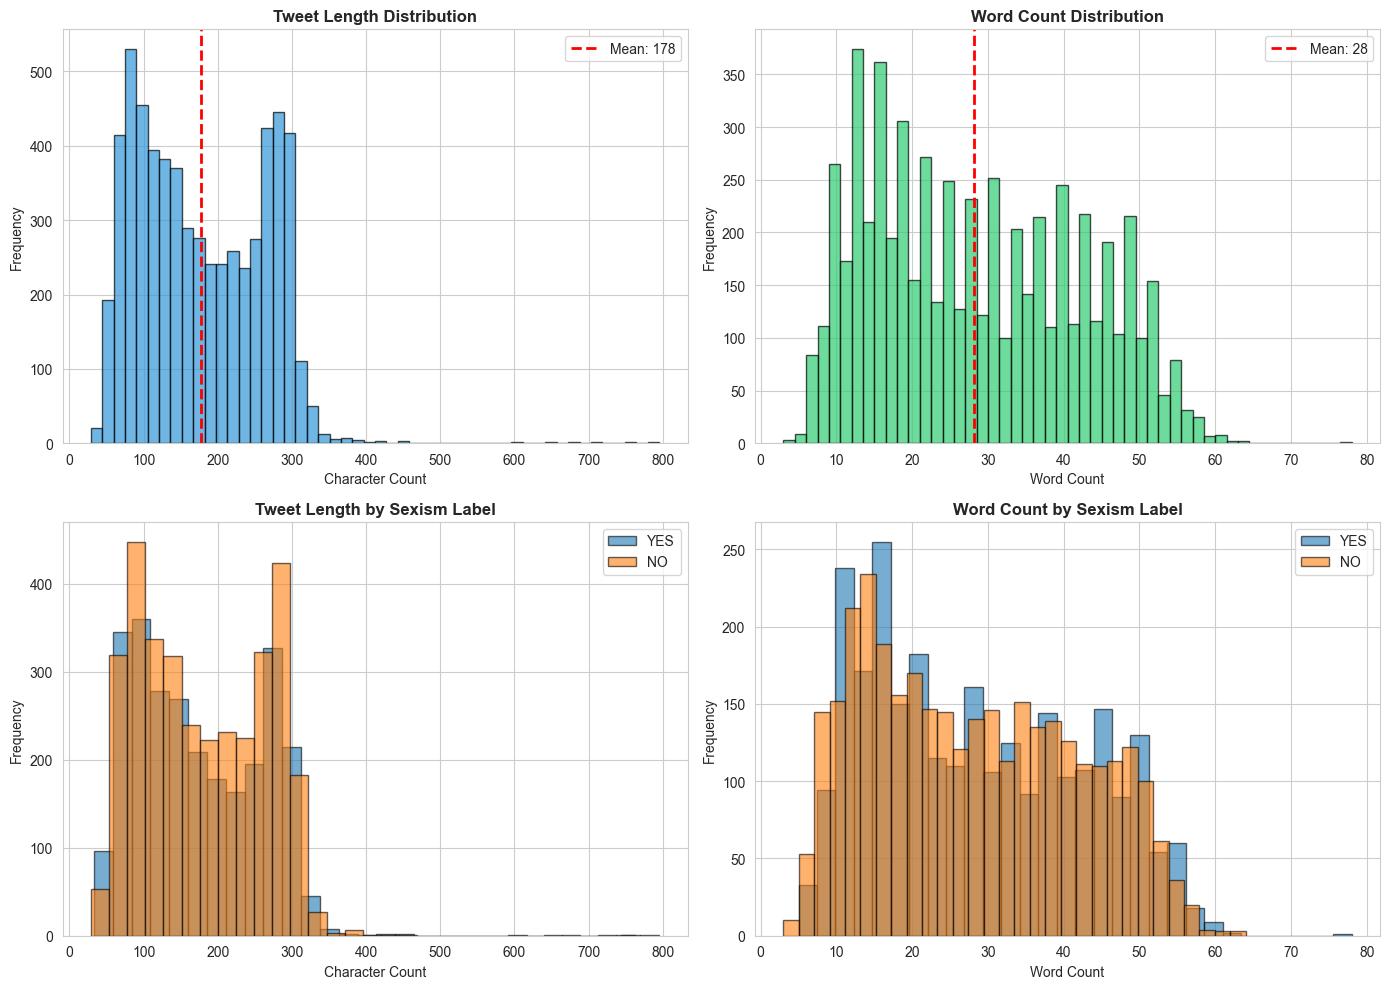

In [35]:
# Visualize text statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tweet length distribution
axes[0, 0].hist(df_train['tweet_length'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Tweet Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_train['tweet_length'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df_train["tweet_length"].mean():.0f}')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(df_train['word_count'], bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_train['word_count'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df_train["word_count"].mean():.0f}')
axes[0, 1].legend()

# Text length by label
for label in ['YES', 'NO']:
    subset = df_train[df_train['task1_majority'] == label]
    axes[1, 0].hist(subset['tweet_length'], bins=30, alpha=0.6, label=label, edgecolor='black')
axes[1, 0].set_title('Tweet Length by Sexism Label', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Word count by label
for label in ['YES', 'NO']:
    subset = df_train[df_train['task1_majority'] == label]
    axes[1, 1].hist(subset['word_count'], bins=30, alpha=0.6, label=label, edgecolor='black')
axes[1, 1].set_title('Word Count by Sexism Label', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 6. Vocabulary Analysis

In [36]:
# Extract vocabulary
from collections import defaultdict

def get_vocabulary(df):
    vocab = defaultdict(int)
    for tweet in df['tweet']:
        for word in tweet.lower().split():
            vocab[word] += 1
    return vocab

vocab_train = get_vocabulary(df_train)
vocab_sexist = get_vocabulary(df_train[df_train['task1_majority'] == 'YES'])
vocab_non_sexist = get_vocabulary(df_train[df_train['task1_majority'] == 'NO'])

print(f"Total vocabulary size: {len(vocab_train)}")
print(f"Sexist tweets vocabulary: {len(vocab_sexist)}")
print(f"Non-sexist tweets vocabulary: {len(vocab_non_sexist)}")

Total vocabulary size: 44891
Sexist tweets vocabulary: 22198
Non-sexist tweets vocabulary: 29449


In [37]:
# Most common words
print("\nTop 20 most common words (all tweets):")
for word, count in sorted(vocab_train.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"  {word}: {count}")


Top 20 most common words (all tweets):
  de: 4112
  a: 3898
  que: 2994
  la: 2802
  the: 2603
  y: 2511
  to: 1942
  el: 1882
  no: 1746
  and: 1626
  en: 1594
  of: 1362
  es: 1178
  i: 1177
  is: 1078
  las: 979
  me: 964
  los: 921
  un: 896
  in: 871


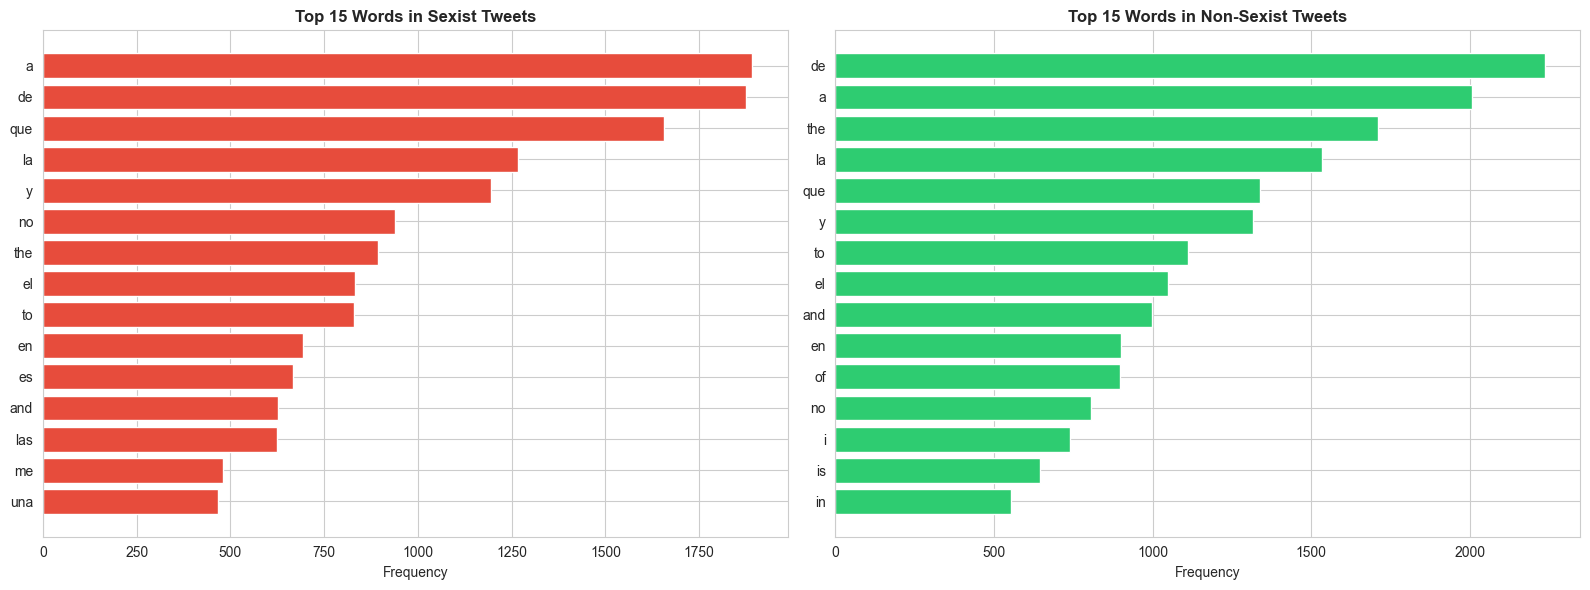

In [38]:
# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top words in sexist tweets
top_sexist = sorted(vocab_sexist.items(), key=lambda x: x[1], reverse=True)[:15]
words, counts = zip(*top_sexist)
axes[0].barh(range(len(words)), counts, color='#e74c3c')
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].set_title('Top 15 Words in Sexist Tweets', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

# Top words in non-sexist tweets
top_non_sexist = sorted(vocab_non_sexist.items(), key=lambda x: x[1], reverse=True)[:15]
words, counts = zip(*top_non_sexist)
axes[1].barh(range(len(words)), counts, color='#2ecc71')
axes[1].set_yticks(range(len(words)))
axes[1].set_yticklabels(words)
axes[1].set_title('Top 15 Words in Non-Sexist Tweets', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Special Characters and Patterns

In [39]:
# Analyze special patterns
df_train['has_mention'] = df_train['tweet'].str.contains('@', regex=False)
df_train['has_hashtag'] = df_train['tweet'].str.contains('#', regex=False)
df_train['has_url'] = df_train['tweet'].str.contains('http', regex=False)
df_train['has_emoji'] = df_train['tweet'].str.contains('[\U0001F600-\U0001F64F]', regex=True)

print("Special pattern statistics:")
print(f"Tweets with mentions: {df_train['has_mention'].sum()} ({df_train['has_mention'].mean()*100:.1f}%)")
print(f"Tweets with hashtags: {df_train['has_hashtag'].sum()} ({df_train['has_hashtag'].mean()*100:.1f}%)")
print(f"Tweets with URLs: {df_train['has_url'].sum()} ({df_train['has_url'].mean()*100:.1f}%)")
print(f"Tweets with emojis: {df_train['has_emoji'].sum()} ({df_train['has_emoji'].mean()*100:.1f}%)")

Special pattern statistics:
Tweets with mentions: 3244 (53.5%)
Tweets with hashtags: 862 (14.2%)
Tweets with URLs: 1945 (32.1%)
Tweets with emojis: 459 (7.6%)


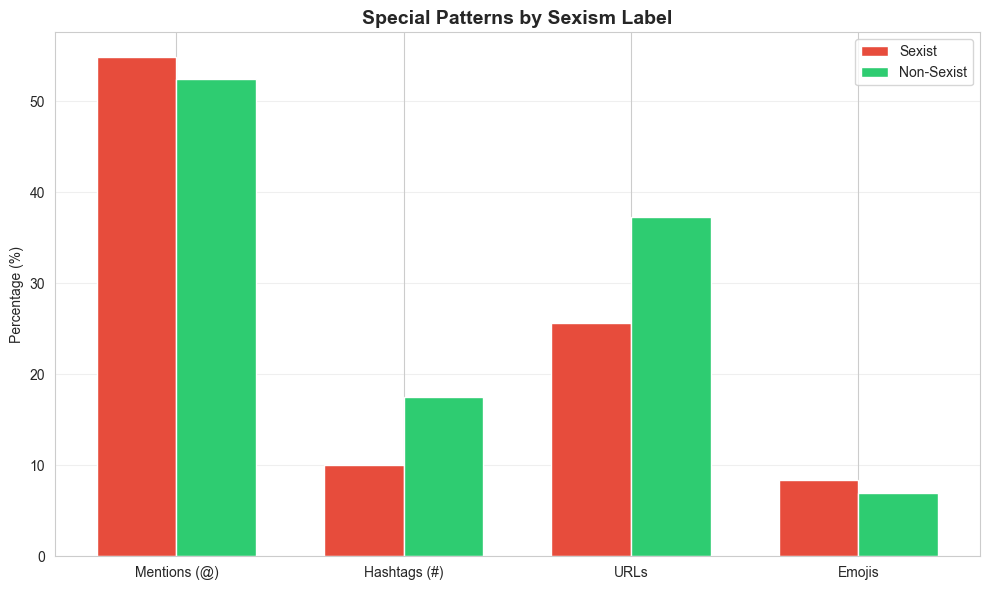

In [40]:
# Visualize special patterns by label
patterns = ['has_mention', 'has_hashtag', 'has_url', 'has_emoji']
pattern_names = ['Mentions (@)', 'Hashtags (#)', 'URLs', 'Emojis']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(patterns))
width = 0.35

yes_percentages = [df_train[df_train['task1_majority'] == 'YES'][p].mean() * 100 for p in patterns]
no_percentages = [df_train[df_train['task1_majority'] == 'NO'][p].mean() * 100 for p in patterns]

ax.bar(x - width/2, yes_percentages, width, label='Sexist', color='#e74c3c')
ax.bar(x + width/2, no_percentages, width, label='Non-Sexist', color='#2ecc71')

ax.set_ylabel('Percentage (%)')
ax.set_title('Special Patterns by Sexism Label', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pattern_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Data Split Verification

In [41]:
# Verify data splits
print("Training data splits:")
print(df_train['split'].value_counts())

print("\nTest data splits:")
print(df_test['split'].value_counts())

print("\nID ranges:")
print(f"Training IDs: {df_train['id'].min()} - {df_train['id'].max()}")
print(f"Test IDs: {df_test['id'].min()} - {df_test['id'].max()}")

Training data splits:
split
TRAIN_ES    3194
TRAIN_EN    2870
Name: count, dtype: int64

Test data splits:
split
DEV_ES    490
DEV_EN    444
Name: count, dtype: int64

ID ranges:
Training IDs: 100001 - 203260
Test IDs: 300002 - 400489


## 8. Feature Correlation Analysis

### 8.1. Correlation Matrix for Numerical Features

In [ ]:
# Prepare numerical features for correlation analysis
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.feature_selection import mutual_info_classif

# Convert task1_majority to binary
df_train['task1_binary'] = (df_train['task1_majority'] == 'YES').astype(int)

# Select numerical features
numerical_features = ['tweet_length', 'word_count', 'avg_word_length', 
                      'task1_agreement', 'num_annotators']
categorical_features = ['has_mention', 'has_hashtag', 'has_url', 'has_emoji']

# Create correlation matrix for numerical features
correlation_data = df_train[numerical_features + ['task1_binary']].corr()

print("Correlation Matrix:")
print(correlation_data)

In [ ]:
# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 8.2. Point-Biserial Correlation (Numerical vs Binary Target)

In [ ]:
# Calculate point-biserial correlation for numerical features vs target
correlations = {}
p_values = {}

for feature in numerical_features:
    corr, p_val = pointbiserialr(df_train['task1_binary'], df_train[feature])
    correlations[feature] = corr
    p_values[feature] = p_val

# Display results
corr_df = pd.DataFrame({
    'Feature': numerical_features,
    'Correlation': [correlations[f] for f in numerical_features],
    'P-value': [p_values[f] for f in numerical_features],
    'Significant': [p_values[f] < 0.05 for f in numerical_features]
}).sort_values('Correlation', key=abs, ascending=False)

print("Point-Biserial Correlation with Task 1 (Sexism):")
print(corr_df.to_string(index=False))

In [ ]:
# Visualize correlations with target
plt.figure(figsize=(10, 6))
colors = ['green' if p < 0.05 else 'gray' for p in corr_df['P-value']]
plt.barh(corr_df['Feature'], corr_df['Correlation'], color=colors)
plt.xlabel('Point-Biserial Correlation')
plt.title('Feature Correlation with Sexism Label (Task 1)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNote: Green bars indicate statistically significant correlations (p < 0.05)")

### 8.3. Chi-Square Test for Categorical Features

In [ ]:
# Chi-square test for categorical features
chi2_results = {}

for feature in categorical_features:
    contingency_table = pd.crosstab(df_train[feature], df_train['task1_majority'])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    chi2_results[feature] = {
        'chi2': chi2,
        'p_value': p_val,
        'dof': dof,
        'significant': p_val < 0.05
    }

# Display results
chi2_df = pd.DataFrame(chi2_results).T
chi2_df = chi2_df.sort_values('chi2', ascending=False)

print("Chi-Square Test Results (Categorical Features vs Task 1):")
print(chi2_df[['chi2', 'p_value', 'significant']])

In [ ]:
# Visualize chi-square statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chi-square values
colors = ['green' if chi2_df.loc[f, 'significant'] else 'gray' for f in chi2_df.index]
axes[0].barh(chi2_df.index, chi2_df['chi2'], color=colors)
axes[0].set_xlabel('Chi-Square Statistic')
axes[0].set_title('Chi-Square Test: Categorical Features', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# P-values (log scale)
axes[1].barh(chi2_df.index, -np.log10(chi2_df['p_value']), color=colors)
axes[1].set_xlabel('-log10(p-value)')
axes[1].set_title('Statistical Significance', fontsize=12, fontweight='bold')
axes[1].axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Green bars indicate statistically significant associations (p < 0.05)")

### 8.4. Mutual Information Analysis

In [ ]:
# Calculate mutual information for all features
all_features = numerical_features + categorical_features
X_features = df_train[all_features].values
y_target = df_train['task1_binary'].values

mi_scores = mutual_info_classif(X_features, y_target, random_state=42)

# Create results dataframe
mi_df = pd.DataFrame({
    'Feature': all_features,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Mutual Information Scores:")
print(mi_df.to_string(index=False))

In [ ]:
# Visualize mutual information scores
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='#3498db')
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance: Mutual Information with Task 1', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 8.5. Feature Redundancy Analysis

In [ ]:
# Check for highly correlated features (potential redundancy)
threshold = 0.8
high_corr_pairs = []

for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        corr_val = correlation_data.loc[numerical_features[i], numerical_features[j]]
        if abs(corr_val) > threshold:
            high_corr_pairs.append({
                'Feature_1': numerical_features[i],
                'Feature_2': numerical_features[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    print(f"Highly correlated feature pairs (|r| > {threshold}):")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature_1']} <-> {pair['Feature_2']}: {pair['Correlation']:.3f}")
else:
    print(f"No highly correlated feature pairs found (threshold: {threshold})")

### 8.6. Feature Selection Recommendations

In [ ]:
# Generate feature selection recommendations
print("=" * 60)
print("FEATURE SELECTION RECOMMENDATIONS")
print("=" * 60)

print("\nMost informative features (MI > 0.01):")
informative_features = mi_df[mi_df['MI_Score'] > 0.01]
for idx, row in informative_features.iterrows():
    print(f"  - {row['Feature']}: MI = {row['MI_Score']:.4f}")

print("\nLeast informative features (MI < 0.005):")
uninformative_features = mi_df[mi_df['MI_Score'] < 0.005]
if len(uninformative_features) > 0:
    for idx, row in uninformative_features.iterrows():
        print(f"  - {row['Feature']}: MI = {row['MI_Score']:.4f}")
    print("\n  Recommendation: Consider removing these features")
else:
    print("  All features show some level of information")

print("\nStatistically significant features:")
print("  Numerical features (p < 0.05):")
for _, row in corr_df[corr_df['Significant']].iterrows():
    print(f"    - {row['Feature']}: r = {row['Correlation']:.4f}, p = {row['P-value']:.4e}")

print("\n  Categorical features (p < 0.05):")
for feature in chi2_df[chi2_df['significant']].index:
    print(f"    - {feature}: χ² = {chi2_df.loc[feature, 'chi2']:.2f}, p = {chi2_df.loc[feature, 'p_value']:.4e}")

print("=" * 60)

## 9. Summary of Key Findings

In [ ]:
# Generate summary report
print("=" * 60)
print("EXIST2025 Dataset Exploration Summary")
print("=" * 60)
print(f"\nDataset Size:")
print(f"  Training samples: {len(df_train)}")
print(f"  Test samples: {len(df_test)}")
print(f"\nTask 1 (Binary Classification):")
print(f"  Sexist (YES): {task1_counts.get('YES', 0)} ({task1_counts.get('YES', 0)/len(df_train)*100:.1f}%)")
print(f"  Non-Sexist (NO): {task1_counts.get('NO', 0)} ({task1_counts.get('NO', 0)/len(df_train)*100:.1f}%)")
print(f"  Class imbalance ratio: 1:{task1_counts['NO'] / task1_counts.get('YES', 1):.2f}")
print(f"\nAnnotator Agreement:")
print(f"  Mean agreement: {df_train['task1_agreement'].mean():.3f}")
print(f"  Median agreement: {df_train['task1_agreement'].median():.3f}")
print(f"  Perfect agreement (1.0): {(df_train['task1_agreement'] == 1.0).sum()} samples")
print(f"\nText Characteristics:")
print(f"  Average tweet length: {df_train['tweet_length'].mean():.0f} characters")
print(f"  Average word count: {df_train['word_count'].mean():.0f} words")
print(f"  Vocabulary size: {len(vocab_train)} unique words")
print(f"\nSpecial Features:")
print(f"  Tweets with mentions: {df_train['has_mention'].mean()*100:.1f}%")
print(f"  Tweets with hashtags: {df_train['has_hashtag'].mean()*100:.1f}%")
print(f"  Tweets with URLs: {df_train['has_url'].mean()*100:.1f}%")
print("=" * 60)

EXIST2025 Dataset Exploration Summary

Dataset Size:
  Training samples: 6064
  Test samples: 934

Task 1 (Binary Classification):
  Sexist (YES): 2697 (44.5%)
  Non-Sexist (NO): 3367 (55.5%)
  Class imbalance ratio: 1:1.25

Annotator Agreement:
  Mean agreement: 0.846
  Median agreement: 0.833
  Perfect agreement (1.0): 2249 samples

Text Characteristics:
  Average tweet length: 178 characters
  Average word count: 28 words
  Vocabulary size: 44891 unique words

Special Features:
  Tweets with mentions: 53.5%
  Tweets with hashtags: 14.2%
  Tweets with URLs: 32.1%
